In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as pl
import matplotlib.pyplot as plt
import scipy.optimize as opt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
import re
data = pd.read_csv('cars.csv')
print(data.isna().sum())
data['mileage'].fillna(data['mileage'].mean(),inplace=True)
data['engine'].fillna(data['engine'].mean(),inplace=True)
data['max_power'].fillna(data['max_power'].mean(),inplace=True)
data['seats'].fillna(data['seats'].mean(),inplace=True)
data.drop(['torque','owner','seller_type'],axis=1,inplace=True)
typex = pd.get_dummies(data['transmission'],drop_first=True)
data['Transmission']= typex

name              0
year              0
selling_price     0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage          29
engine           29
max_power        27
torque           29
seats            29
dtype: int64


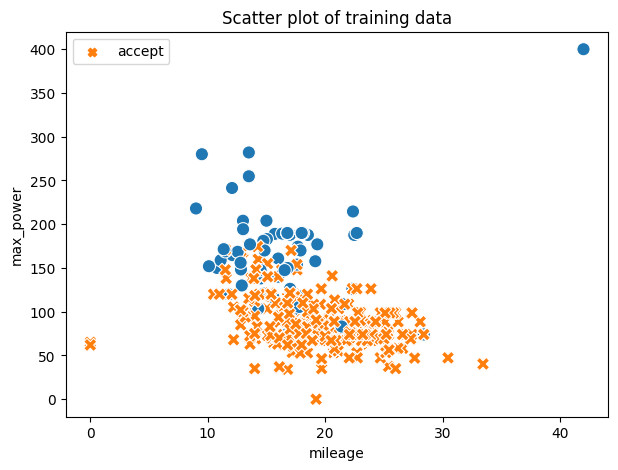

In [3]:
plt.figure(figsize=(7, 5))
ax = sns.scatterplot(x='mileage',y='max_power', hue='Transmission', data=data, style='Transmission', s=90)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], ['accept', 'Refuse'])
plt.title('Scatter plot of training data')
plt.show()
def sigmoid(z):
    z = np.array(z)
    return 1 / (1+np.exp(-z))

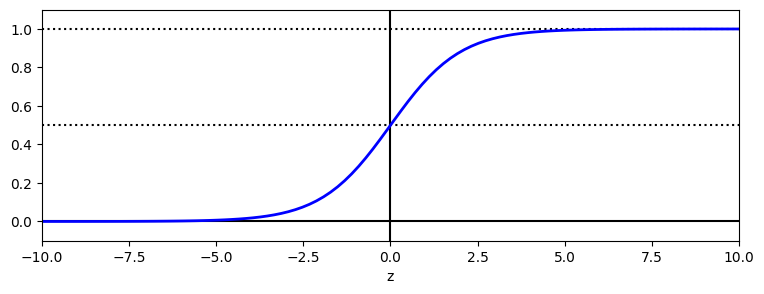

In [4]:
import matplotlib.pyplot as plt

#matplotlib inline
z = np.linspace(-10, 10, 100)
sig = sigmoid(z)
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(z, sig, "b-", linewidth=2)
plt.xlabel("z")
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

In [5]:
def cost_function(theta, X, y):
    m = y.shape[0]
    theta = theta[:, np.newaxis] #trick to make numpy minimize work
    h = sigmoid(X.dot(theta))
    J = (1/m) * (-y.T.dot(np.log(h)) - (1-y).T.dot(np.log(1-h)))

    diff_hy = h - y
    grad = (1/m) * diff_hy.T.dot(X)

    return J, grad

In [6]:
m = data.shape[0]
X = np.hstack((np.ones((m,1)),data[['mileage', 'max_power']].values))
y = np.array(data.Transmission.values).reshape(-1,1)
initial_theta = np.zeros(shape=(X.shape[1]))
cost, grad = cost_function(initial_theta, X, y)
print('Cost at initial theta (zeros):', cost)
print('Expected cost (approx): 0.693')
print('Gradient at initial theta (zeros):')
print(grad.T)
print('Expected gradients (approx):\n -0.1000\n -12.0092\n -11.2628')
test_theta = np.array([-24, 0.2, 0.2])
[cost, grad] = cost_function(test_theta, X, y)

Cost at initial theta (zeros): [[0.69314718]]
Expected cost (approx): 0.693
Gradient at initial theta (zeros):
[[ -0.37287287]
 [ -7.40793701]
 [-26.78284442]]
Expected gradients (approx):
 -0.1000
 -12.0092
 -11.2628


<ipython-input-5-0ae0752fca4a>:5: RuntimeWarning: divide by zero encountered in log
  J = (1/m) * (-y.T.dot(np.log(h)) - (1-y).T.dot(np.log(1-h)))


In [7]:
print('Cost at test theta:', cost)
print('Expected cost (approx): 0.218')
print('Gradient at test theta:')
print(grad.T)
print('Expected gradients (approx):\n 0.043\n 2.566\n 2.647')

Cost at test theta: [[inf]]
Expected cost (approx): 0.218
Gradient at test theta:
[[ -0.62082256]
 [-12.68689493]
 [-37.38250273]]
Expected gradients (approx):
 0.043
 2.566
 2.647


In [8]:
def optimize_theta(X, y, initial_theta):
    opt_results = opt.minimize(cost_function, initial_theta, args=(X, y), method='TNC',jac=True, options={'maxiter':400})
    return opt_results['x'], opt_results['fun']

opt_theta, cost = optimize_theta(X, y, initial_theta)
print('Cost at theta found by fminunc:', cost)
print('Expected cost (approx): 0.203')
print('theta:\n', opt_theta.reshape(-1,1))
print('Expected theta (approx):')
print(' -25.161\n 0.206\n 0.201')

Cost at theta found by fminunc: 0.24606389620780686
Expected cost (approx): 0.203
theta:
 [[ 7.59187607]
 [-0.04573768]
 [-0.04528572]]
Expected theta (approx):
 -25.161
 0.206
 0.201


<ipython-input-8-faf7b3fed9f0>:2: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  opt_results = opt.minimize(cost_function, initial_theta, args=(X, y), method='TNC',jac=True, options={'maxiter':400})


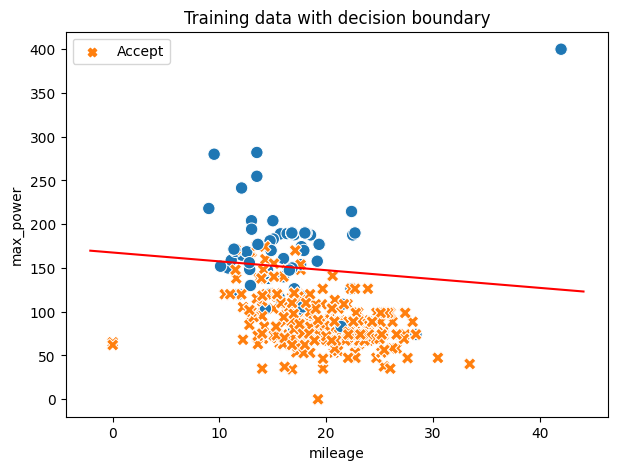

In [9]:
plt.figure(figsize=(7,5))
ax = sns.scatterplot(x='mileage', y='max_power', hue='Transmission', data=data, style='Transmission', s=80)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], ['Accept', 'Refuse'])
plt.title('Training data with decision boundary')

plot_x = np.array(ax.get_xlim())
plot_y = (-1/opt_theta[2]*(opt_theta[1]*plot_x + opt_theta[0]))
plt.plot(plot_x, plot_y, '-', c="red")


In [10]:
prob = sigmoid(np.array([1, 45, 85]).dot(opt_theta))
print('Expected value: 0.775 +/- 0.002')

Expected value: 0.775 +/- 0.002


In [11]:
def predict(X, theta):
    y_pred = [1 if sigmoid(X[i, :].dot(theta)) >= 0.5 else 0 for i in range(0, X.shape[0])]
    return y_pred
X = np.hstack((np.ones((m,1)),data[['mileage', 'max_power']].values))

y_pred_prob = predict(X, opt_theta)
print(f'Train accuracy: {np.mean(y_pred_prob == data.Transmission.values) * 100}')

Train accuracy: 91.991991991992
